# ***`How to interpret the model behavior?`***

---
#### ***The objective for creating this notebook is to understand and work with various `Model Agnostic(means model independent)` techniques for interpretating the models behavior or prediction. Also, what are their advantages and disadvantages.***
---

#### **Notebook Contents**

1. [Library Import](#Packages_Import)
2. [Load Dataset](#Dataset_Creation)
3. [Models Instantiation](#Models_Instantiation)
4. [Working with SHAP](#Working_with_SHAP)
5. [Feature Prediction Parameters with Eli5](#Feature_Prediction_Parameters)
6. [Future Topic](#Future_Topics)

### **Very Important Read outs**
---
**`SHAP`** :: 

https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

https://towardsdatascience.com/black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d

---

**`Model Interpretability`** :: 

https://christophm.github.io/interpretable-ml-book/agnostic.html

---

#### **Packages_Import**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import shap
import lime
import eli5

from sklearn.datasets import load_breast_cancer, load_diabetes
from sklearn.inspection import plot_partial_dependence, permutation_importance
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

pd.set_option('display.max_columns',50)

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


#### **Dataset_Creation**

In [2]:
lbc = load_breast_cancer()
ld = load_diabetes()

In [3]:
lbc.target_names, np.unique(lbc.target)

(array(['malignant', 'benign'], dtype='<U9'), array([0, 1]))

In [4]:
X_can = pd.DataFrame(lbc.data,columns=lbc.feature_names)
y_can = pd.DataFrame(lbc.target,columns=['Label'])

In [5]:
X_cancer = X_can.iloc[:,0:9].copy(deep=True)
y_cancer = y_can.copy(deep=True)
# y_dict = {0:99,1:11}
# y_cancer = y_cancer['Label'].apply(lambda val: y_dict.get(val))

In [6]:
X_diab = pd.DataFrame(ld.data,columns=ld.feature_names)
y_diab = pd.DataFrame(ld.target,columns=['Label'])

In [7]:
X_cancer.shape, y_cancer.shape, X_diab.shape, y_diab.shape

((569, 9), (569, 1), (442, 10), (442, 1))

In [8]:
X_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809


In [9]:
pd.DataFrame(y_cancer.value_counts())

,0
Label,
1,357
0,212


In [10]:
X_diab.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


#### **Train and Test sets creation for Cancer Dataset**

In [11]:
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer,y_cancer,
                                                                                test_size=0.33,
                                                                                stratify=y_cancer,
                                                                                random_state=41)

In [12]:
X_train_cancer = pd.DataFrame(X_train_cancer,columns=X_cancer.columns)
X_test_cancer = pd.DataFrame(X_test_cancer,columns=X_cancer.columns)

In [13]:
X_train_cancer.shape, X_test_cancer.shape, y_train_cancer.shape, y_test_cancer.shape

((381, 9), (188, 9), (381, 1), (188, 1))

#### **Train and Test sets creation for Diabetes Dataset**

In [14]:
X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X_diab,y_diab,
                                                                                test_size=0.2,
                                                                                random_state=11)

In [15]:
X_train_diab = pd.DataFrame(X_train_diab,columns=ld.feature_names)
X_test_diab = pd.DataFrame(X_test_diab,columns=ld.feature_names)

In [16]:
X_train_diab.shape, X_test_diab.shape, y_train_diab.shape, y_test_diab.shape

((353, 10), (89, 10), (353, 1), (89, 1))

#### **Models_Instantiation**

In [17]:
dtc = DecisionTreeClassifier(max_depth=5,min_samples_leaf=5,min_samples_split=5,random_state=42)

In [18]:
rf = RandomForestClassifier(n_estimators=15,max_depth=5,min_samples_leaf=5,min_samples_split=5,random_state=42)

#### **Models_Training**

In [19]:
dtc.fit(X_train_cancer,np.ravel(y_train_cancer.values))

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                       random_state=42)

In [20]:
rf.fit(X_train_cancer,np.ravel(y_train_cancer.values))

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=15, random_state=42)

#### **Models_Features_Importances**
##### **Calculated based on the concept of Information Theory means calculating the importance score by the IG achieved by using a particular feature.**

##### **Decision :: Feature Importance**

In [21]:
dtc_feat_imps = pd.DataFrame(dtc.feature_importances_).T
dtc_feat_imps.columns = X_cancer.columns
dtc_feat_imps

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,0.0,0.088582,0.008477,0.073983,0.011875,0.0,0.002315,0.814768,0.0


In [22]:
dtc_most_imp_feats = np.round(dtc_feat_imps.T.sort_values(by=[0],axis=0,ascending=False).reset_index(drop=False),3)
dtc_most_imp_feats.columns = ['Features','Importance']

In [23]:
np.sum(dtc_most_imp_feats['Importance'])

0.9999999999999999

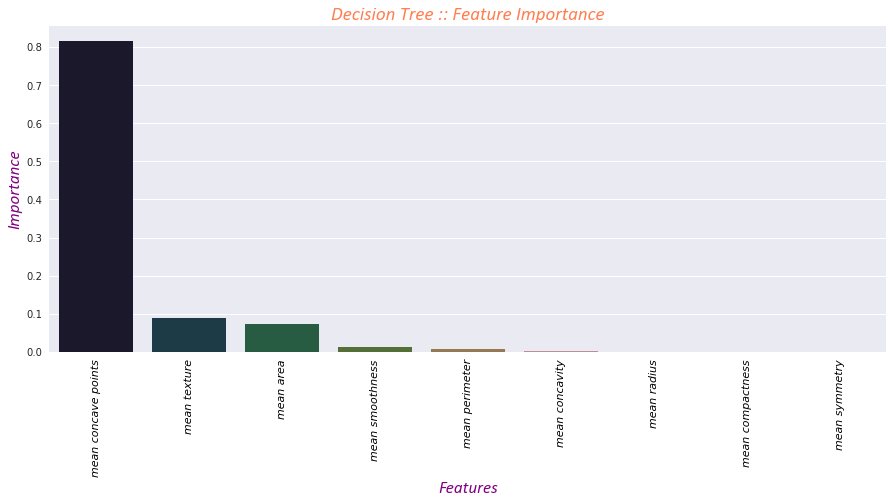

In [24]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,6))
    sns.barplot(data=dtc_most_imp_feats,x='Features',y='Importance',palette='cubehelix')
    plt.xticks(size=11,rotation=90,style='oblique',color='k')
    plt.xlabel(xlabel='Features', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.ylabel(ylabel='Importance', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.title(label="Decision Tree :: Feature Importance", fontdict={'size':19,'family':'calibri','style':'oblique','color':'coral'})

#### **So ,as per decision tree `mean concave points` is the most important feature for predicting the existence of cancer. Majority of features are having 0 score and it looks like model prediction is only relying on `worst concave points`.**

##### **Random_Forest :: Feature Importance**

In [25]:
rf_feat_imps = pd.DataFrame(rf.feature_importances_).T
rf_feat_imps.columns = X_cancer.columns
rf_feat_imps

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,0.078496,0.036547,0.231095,0.065353,0.008873,0.01771,0.036479,0.522904,0.002543


In [26]:
rf_most_imp_feats = np.round(rf_feat_imps.T.sort_values(by=[0],axis=0,ascending=False).reset_index(drop=False),3)
rf_most_imp_feats.columns = ['Features','Importance']

In [27]:
np.sum(rf_most_imp_feats['Importance'])

1.0

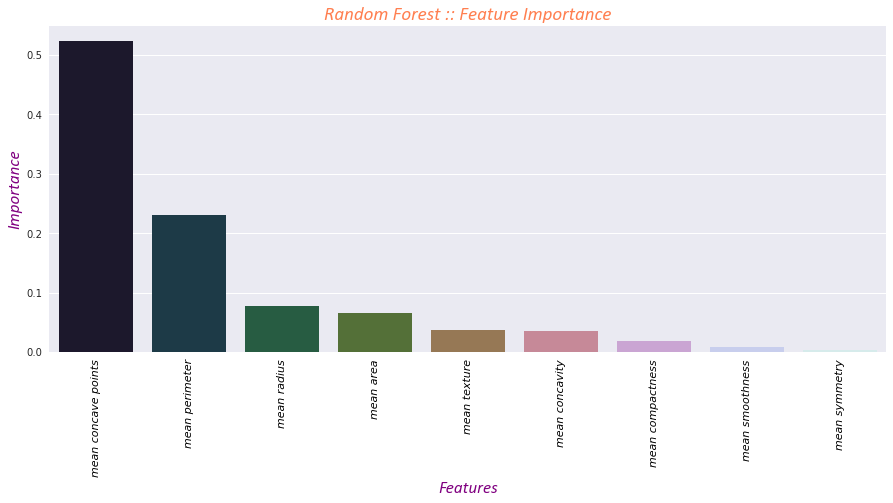

In [28]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(15,6))
    sns.barplot(data=rf_most_imp_feats,x='Features',y='Importance',palette='cubehelix')
    plt.xticks(size=11,rotation=90,style='oblique',color='k')
    plt.xlabel(xlabel='Features', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.ylabel(ylabel='Importance', fontdict={'size':17,'family':'calibri','style':'oblique','color':'Purple'})
    plt.title(label="Random Forest :: Feature Importance", fontdict={'size':19,'family':'calibri','style':'oblique','color':'coral'})

#### **So ,as per random forest `mean concave points` is the most important feature for predicting the existence of cancer, but it is not the only feature that is playing important role in prediction and some of the other features are also giving input.**

## **Working_with_SHAP**
#### ***`Shapely Additive Explanations`***
https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

In [29]:
shap.initjs()

#### **Various SHAP Explainers are available and out of those I'm using the TREE Explainer because I'working with TREE based models.**

In [30]:
rf_shap_explainer = shap.TreeExplainer(rf,
                                       data=X_train_cancer)
#                                         feature_perturbation='interventional',
#                                         model_output='probability')

In [31]:
rf_shap_explainer.expected_value

array([0.38843509, 0.61156491])

#### **Now, the base values of class-0 and class-1  are 0.39 and 0.61 respectively.**

### **Generating the `SHAP values` of `TRAINING` Dataset**

In [33]:
rf_shap_values = rf_shap_explainer.shap_values(X_train_cancer)

In [36]:
type(rf_shap_values)

list

In [37]:
len(rf_shap_values)

2

##### **The SHAP values are returned in the list format; individuals list for the target classes. As seen above, the length of the shape values object is 2 matching with the total number of target classes.**

In [42]:
np.array(rf_shap_values[0]).shape, np.array(rf_shap_values[1]).shape, X_train_cancer.shape

((381, 9), (381, 9), (381, 9))

##### **Here, we can see that the shape of the SHAP values list for the target classes matches with the train dataset shape.**

In [43]:
## Displaying the top-5 records of training data
pd.concat([X_train_cancer,y_train_cancer],axis=1).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,Label
229,12.83,22.33,85.26,503.2,0.10880,0.17990,0.16950,0.06861,0.2123,0
288,11.26,19.96,73.72,394.1,0.08020,0.11810,0.09274,0.05588,0.2595,1
532,13.68,16.33,87.76,575.5,0.09277,0.07255,0.01752,0.01880,0.1631,1
132,16.16,21.54,106.20,809.8,0.10080,0.12840,0.10430,0.05613,0.2160,0
448,14.53,19.34,94.25,659.7,0.08388,0.07800,0.08817,0.02925,0.1473,1


In [44]:
## Displaying the SHAP values of top-5 records w.r.t Class-0(Benign)
c1 = pd.DataFrame(rf_shap_values[0], columns = X_cancer.columns)
c1.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,0.003673,0.078106,-0.025575,-0.006963,-0.000206,0.037357,0.093919,0.283840,5.140433e-05
1,-0.051322,-0.007487,-0.116350,-0.041524,0.003690,-0.021496,-0.002470,0.089030,6.106659e-07
2,-0.042952,-0.034492,-0.058773,-0.056948,0.005779,-0.024300,-0.036289,-0.132376,-3.711845e-04
3,0.086787,0.041517,0.113064,0.084144,0.001471,0.003852,0.042915,0.149005,1.745747e-03
4,-0.049496,-0.005973,0.069754,-0.072340,-0.003832,-0.014902,-0.003470,-0.175989,-2.284506e-02


In [46]:
## Displaying the SHAP values of top-5 records w.r.t Class-1(Malignant)
c2 = pd.DataFrame(rf_shap_values[1], columns = X_cancer.columns)
c2.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,-0.003673,-0.078106,0.025575,0.006963,0.000206,-0.037357,-0.093919,-0.283840,-5.140415e-05
1,0.051322,0.007487,0.116350,0.041524,-0.003690,0.021496,0.002470,-0.089030,-6.104732e-07
2,0.042952,0.034492,0.058773,0.056948,-0.005779,0.024300,0.036289,0.132376,3.711844e-04
3,-0.086787,-0.041517,-0.113064,-0.084144,-0.001471,-0.003852,-0.042915,-0.149005,-1.745747e-03
4,0.049496,0.005973,-0.069754,0.072340,0.003832,0.014902,0.003470,0.175989,2.284506e-02


### **Understanding the PLOTS offered in SHAP package**

#### **CASE-I**
##### **Validating the results for 0th Train Record w.r.t Class-0(Benign)**

In [48]:
## Prediction made by trained Random Forest on one of the training records
rf.predict(X_train_cancer.iloc[[0]])

array([0])

##### **The above outcome of zero for the 0th indexed train record means non-cancerous.**

In [49]:
rf.predict_proba(X_train_cancer.iloc[[0]])

array([[0.85263533, 0.14736467]])

##### **Here, the probability of Class-0 is higher as compared to Class-1, thus labelled as Non-Cancerous.**

In [50]:
rf_shap_explainer.expected_value[0]

0.3884350901092673

##### **The base value generated by the TREE Explainer for Class-0(Benign) is 0.39. But, for the 0th record the prediction probability is 0.85.**

In [52]:
## Displaying the SHAPely values for the 0th indexed TRAIN record for Class-0
np.round(rf_shap_values[0][0],3)

array([ 0.004,  0.078, -0.026, -0.007, -0.   ,  0.037,  0.094,  0.284,
        0.   ])

In [53]:
X_train_cancer.iloc[[0]]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
229,12.83,22.33,85.26,503.2,0.1088,0.1799,0.1695,0.06861,0.2123


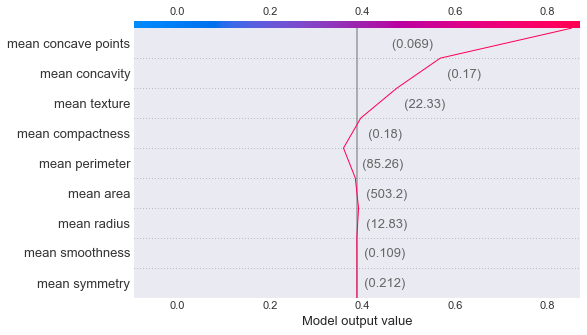

In [57]:
with plt.style.context('seaborn-dark'):
    shap.decision_plot(rf_shap_explainer.expected_value[0],shap_values=rf_shap_values[0][0],features=X_train_cancer.iloc[0])

#### **Now, the above decision plot is telling us which features are primarily responsible for 0.85 model o/p value for this record.**
- **Mean Symmetry, Smoothness, Radius, Area, Perimeter and Compactness all hovers the model output around 0.4 but, the top-3 features Mean Texture, Concavity and Concave Points shifted the prediction result to 0.85.**

In [58]:
shap.plots.force(base_value=rf_shap_explainer.expected_value[0],
                 shap_values=rf_shap_values[0][0],features=X_train_cancer.iloc[0],
                 feature_names=X_train_cancer.columns
                )

#### **Now, the above Force Plot also telling us same details but in a different manner. The base value for Class-0 is 0.388. Looking at above plot we can clearly say that Mean Concavity, Concave Points and Texture shifted the model output from 0.388 to 0.85.**

#### **CASE-II**
##### **Validating the results for 0th Train Record w.r.t Class-1(Malignant)**

In [64]:
rf.predict(X_train_cancer.iloc[[0]])

array([0])

In [65]:
rf.predict_proba(X_train_cancer.iloc[[0]])

array([[0.85263533, 0.14736467]])

In [66]:
## Base value for Class-1
rf_shap_explainer.expected_value[1]

0.6115649098907323

In [67]:
## SHAPely values for the 0th TRAIN record w.r.t CLass-1
np.round(rf_shap_values[1][0],3)

array([-0.004, -0.078,  0.026,  0.007,  0.   , -0.037, -0.094, -0.284,
       -0.   ])

In [68]:
## SHAPely values for the 0th TRAIN record w.r.t CLass-0
np.round(rf_shap_values[0][0],3)

array([ 0.004,  0.078, -0.026, -0.007, -0.   ,  0.037,  0.094,  0.284,
        0.   ])

#### **The above two cells are showing us the difference in the SHAPely values generated for both the classes for 0th TRAIN record.**

In [69]:
X_train_cancer.iloc[[0]]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
229,12.83,22.33,85.26,503.2,0.1088,0.1799,0.1695,0.06861,0.2123


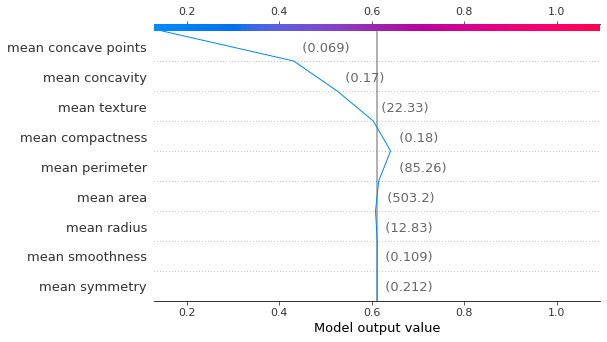

In [70]:
shap.decision_plot(rf_shap_explainer.expected_value[1],shap_values=rf_shap_values[1][0],features=X_train_cancer.iloc[0])

#### **Now, the above decision plot is telling us which features are primarily responsible for 0.15 as the model o/p value for 0th indexed train record.**
- **Mean Symmetry, Smoothness, Radius, Area, Perimeter and Compactness all hovers the model output value around 0.6 but, the top-3 features Mean Texture, Concavity and Concave Points shifted the prediction result to 0.15.**

In [71]:
shap.plots.force(base_value=rf_shap_explainer.expected_value[1],
                 shap_values=rf_shap_values[1][0],features=X_train_cancer.iloc[0],
                 feature_names=X_train_cancer.columns
                )

#### **Now, the above Force Plot also telling us same details but in a different manner. The base value for Class-1 is 0.61. Looking at above plot we can clearly say that Mean Concavity, Concave Points and Texture shifted the model output from 0.61 to 0.15.**

#### **Impact of every feature one the model o/p value**

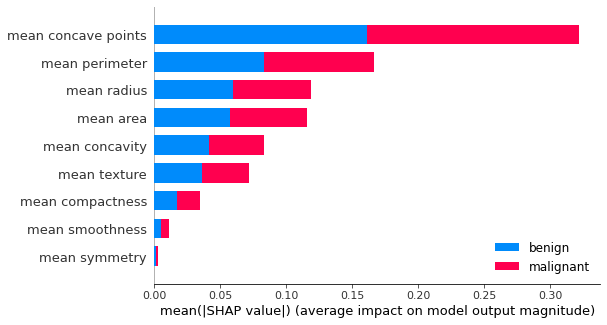

In [73]:
shap.summary_plot(rf_shap_values,
                  features=X_train_cancer.columns,
                  plot_type='bar',
                  class_names=['benign','malignant'],
                  class_inds=[0,1])

In [74]:
pd.concat([X_train_cancer.iloc[[0]],y_train_cancer.iloc[[0]]],axis=1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,Label
229,12.83,22.33,85.26,503.2,0.1088,0.1799,0.1695,0.06861,0.2123,0


In [82]:
rf_shap_explainer.expected_value

array([0.38843509, 0.61156491])

#### **Impact of high or low feature values on the model o/p value**

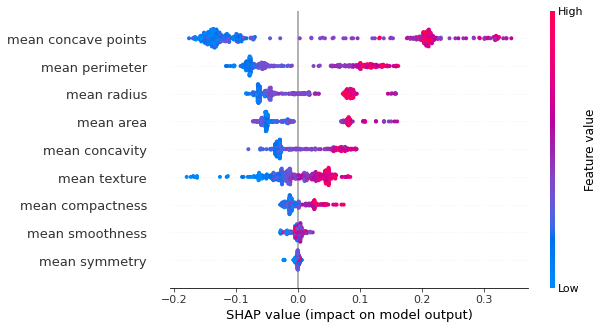

In [81]:
shap.summary_plot(rf_shap_values[0],X_train_cancer)

#### **The above plot is showing the impact of individual feature values on the model o/p w.r.t CLASS-0**
- **For example, the higher values of Mean Concave Points increase the model o/p upto 0.35. And, very low values of it reduce the model o/p by maximum 0.19.**
- **Mean, Symmetry and Smoothness really have very less impact on the model o/p, both of these features are responsible for less than 0.1 variation inthe model o/p.**
- **Low values of Mean Texture are responsible for reducing the model o/p about 0.20.**

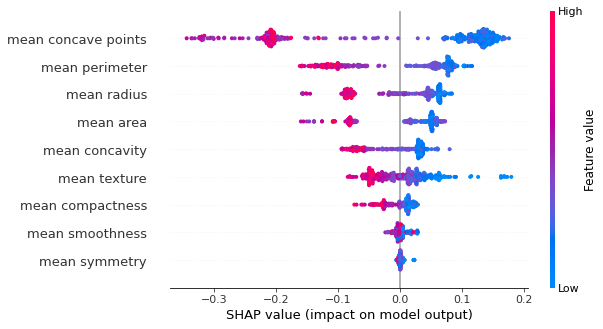

In [83]:
shap.summary_plot(rf_shap_values[1],X_train_cancer)

#### **The above plot is showing the impact of individual feature values on the model o/p w.r.t CLASS-1. And, the results are opposite of CLASS-0 summary plots.**
- **For example, the higher values of Mean Concave Points increase the model o/p upto 0.18. And, lower values of it reduce the model o/p by more than 0.30.**
- **Mean, Symmetry and Smoothness really have very less impact on the model o/p, both of these features are responsible for less than 0.1 variation inthe model o/p.**
- **Low values of Mean Texture are responsible for increasing the model o/p around 0.20.**

#### **CASE-III**
##### **Validating the results for 10th Train Record w.r.t Class-1(Malignant)**

In [93]:
rf.predict(X_train_cancer.iloc[[10]])

array([1])

In [94]:
np.round(rf.predict_proba(X_train_cancer.iloc[[10]]),1)

array([[0., 1.]])

In [95]:
rf_shap_explainer.expected_value[1]

0.6115649098907323

In [106]:
ops = pd.DataFrame(rf_shap_values[1][10]).T
ops.columns = X_train_cancer.columns
ops

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
0,0.064098,0.018208,0.084398,0.050593,0.00075,0.013959,0.031448,0.124304,0.000371


In [107]:
X_train_cancer.iloc[[10]]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry
142,11.43,17.31,73.66,398.0,0.1092,0.09486,0.02031,0.01861,0.1645


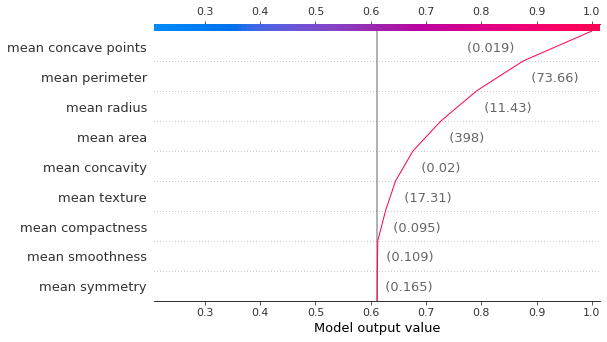

In [108]:
shap.decision_plot(rf_shap_explainer.expected_value[1],shap_values=rf_shap_values[1][10],features=X_train_cancer.iloc[10])

#### **Now, the above decision plot is telling us which features are primarily responsible for 1 as the model o/p value for 10th indexed train record.**
- **Features other than Mean Smoothness and Symmetry shifted the model o/p from 0.6 to 1.0.**

In [109]:
shap.plots.force(base_value=rf_shap_explainer.expected_value[1],
                 shap_values=rf_shap_values[1][10],features=X_train_cancer.iloc[10],
                 feature_names=X_train_cancer.columns
                )

#### **Now, the above Force Plot also telling us same details but in a different manner. The base value for Class-1 is 0.61. Looking at above plot we can clearly say that features other than Mean Smoothness and Symmetry shifted the model output from 0.61 to 1.0.**

#### **Record-wise impact of a feature**
- **`Red` means feature values that `increased the prediction higher than the base/expected value`**
- **`Blue` means feature values that `reduced the prediction lower than the base/expected value`**

In [110]:
rf_shap_explainer.expected_value

array([0.38843509, 0.61156491])

In [111]:
shap.force_plot(rf_shap_explainer.expected_value[0],rf_shap_values[0],X_train_cancer)

#### **In the above plot, we can see that the lower values of Mean Perimeter is reducing the expected value w.r.t Class-0 upto 0.31.**

In [112]:
shap.force_plot(rf_shap_explainer.expected_value[1],rf_shap_values[1],X_train_cancer)

#### **In the above plot, we can see that the higher the values of Mean Area is reducing the expected value w.r.t Class-1 i.e. 0.61 upto 0.49 for one of the records but mainly upto 0.5318.**

## ***Feature_Prediction_Parameters***
#### **Using Eli5 (Explain like I'm 5)**

In [125]:
import eli5

In [140]:
feat_names = list(X_train_cancer.columns)
class_names = ['benign','malignant']
print(feat_names, class_names)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry'] ['benign', 'malignant']


In [143]:
eli5.show_weights(rf,feature_names=feat_names,target_names=class_names)

Weight,Feature
0.5229 ± 0.7405,mean concave points
0.2311 ± 0.6559,mean perimeter
0.0785 ± 0.3743,mean radius
0.0654 ± 0.2772,mean area
0.0365 ± 0.0701,mean texture
0.0365 ± 0.0888,mean concavity
0.0177 ± 0.0543,mean compactness
0.0089 ± 0.0311,mean smoothness
0.0025 ± 0.0165,mean symmetry


In [150]:
eli5.show_prediction(rf,X_train_cancer.iloc[10],feature_names=feat_names,target_names=class_names)

#### **How much a feature is important for the model performance?**
https://medium.com/analytics-vidhya/why-should-i-trust-your-model-bdda6be94c6f

In [170]:
from eli5.sklearn import PermutationImportance

In [172]:
perm = PermutationImportance(rf, scoring="balanced_accuracy")
perm.fit(X_train_cancer, y_train_cancer)
eli5.show_weights(perm, feature_names=feat_names)

Weight,Feature
0.1610 ± 0.0331,mean concave points
0.0289 ± 0.0084,mean texture
0.0204 ± 0.0107,mean radius
0.0132 ± 0.0083,mean perimeter
0.0121 ± 0.0074,mean area
0.0044 ± 0.0069,mean concavity
0.0038 ± 0.0032,mean smoothness
0 ± 0.0000,mean symmetry
-0.0007 ± 0.0039,mean compactness


In [171]:
perm = PermutationImportance(rf, scoring="balanced_accuracy")
perm.fit(X_test_cancer, y_test_cancer)
eli5.show_weights(perm, feature_names=feat_names)

Weight,Feature
0.0992 ± 0.0343,mean concave points
0.0042 ± 0.0000,mean smoothness
0.0017 ± 0.0042,mean symmetry
-0.0006 ± 0.0126,mean concavity
-0.0006 ± 0.0073,mean compactness
-0.0049 ± 0.0059,mean texture
-0.0108 ± 0.0091,mean perimeter
-0.0122 ± 0.0225,mean area
-0.0124 ± 0.0060,mean radius


### ***Future_Topics***
https://www.kaggle.com/dansbecker/partial-dependence-plots